# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: TC5035.10 Proyecto Integrador**
### Tecnológico de Monterrey
### Dra. Grettel Barceló Alonso 
### Dr. Luis Eduardo Falcón Morales

## **Avance 3. Baseline**


**Nombres y matrículas de los integrantes del equipo:**
| Nombre | Matrícula |
| --- | --- |
| Rodrigo López Aguilera | A01793071 |
| Alejandra Mendoza Flores | A01793032 |
| Diego Carrera Nicholls | A00464290 |

## Mejoras sobre el Avance 3

*¿Por qué se cambio el preprocesamiento en ese pipeline?*

El cambio en el preprocesamiento del pipeline se realizó para simplificar el proceso y reducir la complejidad del modelo. Al eliminar la transformación adicional con Box-Cox y utilizar únicamente RobustScaler para las variables numéricas y PowerTransformer con el método "yeo-johnson", se reduce la cantidad de pasos necesarios en el preprocesamiento. Ello presenta un código más limpio y fácil de mantener, y un futuro mejor rendimiento en el modelo final

*¿Por qué en la función get_models() deciden incluir todos los algoritmos de balanceo, cuando en los countplots no todos mostraban buenos resultados? Ej: TomekLinks y EditedNearestNeighbours*
*¿Por qué cuando aplican la regresión logística se deciden por SMOTETomek para el balanceo?*

Para abordar estas preguntas, se volvió a analizar el balanceo de las clases y se ejecutó un modelo simple de regresión logística utilizando stratified kfold para evaluar el desempeño de los algoritmos de balanceo. La métrica de evaluación seleccionada fue "Recall", con el objetivo de minimizar los falsos negativos.

Tras evaluar todos los algoritmos de balanceo, se determinó que SMOTE obtuvo el mejor rendimiento en términos de Recall, alcanzando un valor de 0.8269 en este nuevo análisis.

*¿Por qué deciden usar la métrica de Recall?*

Decidimos utilizar la métrica de Recall, ya que hablando con la persona del negocio con la que tenemos contacto, Gabriel Quintana, el director de marketing nos indica que es más importante para ellos evitar falsos negativos.

Optamos por emplear la métrica de Recall tras conversar con Gabriel Quintana, el director de marketing con quien mantenemos contacto. Según su indicación, es prioritario para el negocio evitar falsos negativos.
Gabriel explicó que en la proyección de ingresos, la cantidad de usuarios activos es fundamental. Pronosticar un número de usuarios no alcanzable puede llevar a estimar incorrectamente las transacciones del mes, lo que conlleva riesgos financieros, como problemas de liquidez. Por tanto, en concordancia con esta prioridad de evitar falsos negativos, elegimos la métrica de Recall para evaluar el desempeño de los modelos de predicción.

*¿Por qué en este pipeline no incluyeron PCA()?*

En este pipeline, decidimos no incluir directamente PCA(). En su lugar, optamos por la selección de características que se identificaron en el avance 2. Esta decisión se tomó con el objetivo de simplificar el pipeline y evitar la pérdida de información que podría ocurrir con PCA.

Sin embargo, en esta última entrega, hemos incorporado un nuevo pipeline que sí incluye PCA con una explicación del 95% de la varianza. Esta adición tiene como propósito simplificar los modelos y reducir el tiempo de entrenamiento.

*¿Por qué usan otra técnica de balanceo? SMOTEENN*

Fue un error de nuestra parte no seguir un proceso adecuado. Agradecemos que nos lo haya hecho notar.

In [106]:
! pip install -q pandas
! pip install -q numpy
! pip install -q matplotlib
! pip install -q seaborn
! pip install -q scikit-learn
! pip install -q imbalanced-learn
! pip install -q Pyarrow

In [107]:
%config Completer.use_jedi = False
# %config InlineBackend.figure_format = 'retina'  # or 'png'
%config InlineBackend.figure_format = 'png'  # or 'png'

In [108]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import PowerTransformer, RobustScaler

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, \
    learning_curve

from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score


# sns.set_context('notebook')
# sns.set_style('whitegrid')

In [109]:
RANDOM_STATE = 42

In [110]:
pd.options.display.float_format = "{:,.2f}".format

Preprocesamiento y Generación de Características de Datos

In [111]:
cleaned_df = pd.read_csv("data/pickwin-active-users.csv")
clean_df = cleaned_df.drop(columns=["days_since_registration"])
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df = clean_df[(clean_df.T != 0).any()]
# feature generation
clean_df["net_winnings"] = clean_df.apply(
    lambda x: x["net_win"] if x["net_win"] > 0 else 0, axis=1
)
clean_df["net_losses"] = clean_df.apply(
    lambda x: x["net_win"] if x["net_win"] < 0 else 0, axis=1
).abs()
# clean_df["winner"] = np.where(clean_df["net_win"] > 0, 1, 0)

# relation of winning bets to total bets
clean_df["win_ratio"] = clean_df["winning_bets"] / clean_df["total_bets"]
# relation of risked money to total bets
clean_df["risk_per_bet"] = clean_df["total_risk"] / clean_df["total_bets"]
# relation of net winnings to total bets
clean_df["net_winnings_per_bet"] = clean_df["net_winnings"] / clean_df["total_bets"]
# relation of net losses to total bets
clean_df["net_losses_per_bet"] = clean_df["net_losses"] / clean_df["total_bets"]

In [112]:
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
purchases_count,"18,099.00",8.88,44.62,1.00,1.00,2.00,4.00,"2,221.00"
purchases_amount,"18,099.00","6,736.74","130,923.72",10.00,100.00,300.00,"1,000.00","12,664,286.00"
cashouts_count,"18,099.00",1.22,6.50,0.00,0.00,0.00,1.00,228.00
cashouts_amount,"18,099.00","5,222.71","92,331.58",0.00,0.00,0.00,400.00,"8,297,350.00"
total_bets,"18,099.00",81.22,760.46,1.00,5.00,13.00,34.00,"67,543.00"
winning_bets,"18,099.00",20.31,210.64,0.00,1.00,2.00,7.00,"17,863.00"
losing_bets,"18,099.00",60.81,565.37,0.00,4.00,10.00,26.00,"49,680.00"
total_risk,"18,099.00","36,671.22","892,191.11",0.00,290.00,760.00,"2,575.00","65,245,852.00"
total_win,"18,099.00","34,961.54","853,467.84",0.00,38.75,323.31,"1,911.00","63,361,273.78"
net_win,"18,099.00","-1,709.69","52,607.06","-4,606,897.53",-705.00,-245.00,-51.31,"1,351,780.57"


In [113]:
X, y = clean_df.drop(["churned"], axis=1), clean_df["churned"]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=RANDOM_STATE, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11764, 16) (6335, 16) (11764,) (6335,)


In [115]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

churned
1   0.93
0   0.07
Name: proportion, dtype: float64
churned
1   0.93
0   0.07
Name: proportion, dtype: float64


Pipeline de preprocesamiento y modelado 

In [116]:
# pipe = Pipeline(steps=[
#     ('RobustScaler', RobustScaler()),
#     ('YeoJohnson', PowerTransformer('yeo-johnson')),
#     # ('SMOTE', SMOTE(random_state=RANDOM_STATE)),
#     # ('pca', PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full")),
# ])

pipe = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
)

pipe

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('robustscaler', RobustScaler()),
                ('powertransformer', PowerTransformer()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full'))])

In [117]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('robustscaler', RobustScaler()),
                ('powertransformer', PowerTransformer()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full'))])

In [118]:
print(pipe.steps[3][1])

PCA(n_components=0.95, random_state=42, svd_solver='full')


In [119]:
pca_model = pipe.steps[3][1]
n_pcs = pca_model.components_.shape[0]
initial_feature_names = X_train.columns
most_important = [np.abs(pca_model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['total_win', 'net_losses_per_bet', 'risk_per_bet', 'net_win', 'win_ratio', 'cashouts_count']


In [120]:
def pca_scree_plot(pca_model):
    # plot the explained variance ratio with a scree plot
    pc_components = np.arange(pca_model.n_components_) + 1

    fig, ax = plt.subplots(figsize=(10, 7))

    cum_sum = np.cumsum(pca_model.explained_variance_ratio_)

    _ = sns.barplot(x=pc_components, y=pca_model.explained_variance_ratio_)
    _ = sns.lineplot(
        x=pc_components - 1,
        y=cum_sum,
        color="black",
        linestyle="-",
        linewidth=2,
        marker="o",
        markersize=8,
    )
    # anotate ticks for cumsum
    for i in range(len(pca_model.explained_variance_ratio_)):
        ax.text(i, cum_sum[i], f"{cum_sum[i]:.2f}", ha="right", va="bottom")

    plt.title("PCA variance")
    plt.xlabel("N-th Principal Component")
    plt.ylabel("Variance")
    plt.ylim(0, 1)
    plt.show()

In [121]:
# Desplegando la matriz de confusión:
# (etiquetas_reales, etiquetas_de_predicciones)
def mi_cm(yreal, ypred):
    cm = confusion_matrix(yreal, ypred)

    txt = [
        "Verdaderos Negativos",
        "Falsos Positivos",
        "Falsos Negativos",
        "Verdaderos Positivos",
    ]
    vf = ["( VN )", "( FP )", "( FN )", "( VP )"]
    frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
    porcentaje = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]

    labels = [
        f"{v1}\n{v2}\n{v3}\n{v4}"
        for v1, v2, v3, v4 in zip(txt, vf, frecuencia, porcentaje)
    ]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", cbar=False)
    ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
    plt.show()

In [122]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, metric, ylim=None):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(f"{metric} Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="b", label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, "+--", color="r", label="Cross-validation score"
    )
    plt.legend(loc="best")
    return plt

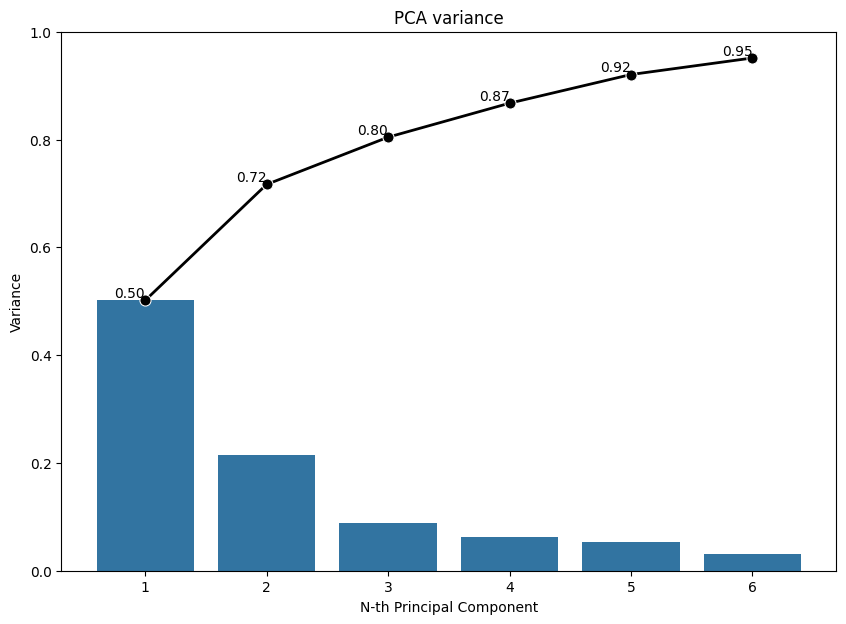

In [123]:
pca_scree_plot(pca_model)

# Análisis de performance de OverSampling y UnderSampling

In [124]:
def get_resampling_models():
    models, names = list(), list()

    models.append(RandomUnderSampler(random_state=RANDOM_STATE))
    names.append("RandomUnderSampler")

    models.append(SMOTE(random_state=RANDOM_STATE))
    names.append("SMOTE")

    models.append(RandomOverSampler(random_state=RANDOM_STATE))
    names.append("RandomOverSampler")

    models.append(SMOTEENN(random_state=RANDOM_STATE))
    names.append("SMOTEENN")

    models.append(SMOTETomek(random_state=RANDOM_STATE))
    names.append("SMOTETomek")

    return models, names

In [125]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

RandomUnderSampler
  Accuracy:	0.8064	(0.0058)
 Precision:	0.9750	(0.0025)
    Recall:	0.8124	(0.0072)
        F1:	0.8863	(0.0039)
    G-Mean:	0.7688	(0.0136)
   ROC AUC:	0.8439	(0.0137)


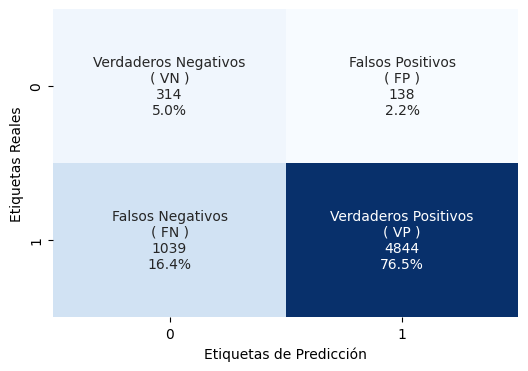

------------------------------------------------------------------------------------------------------------------------
SMOTE
  Accuracy:	0.8180	(0.0056)
 Precision:	0.9731	(0.0022)
    Recall:	0.8269	(0.0066)
        F1:	0.8941	(0.0037)
    G-Mean:	0.7618	(0.0134)
   ROC AUC:	0.8414	(0.0130)


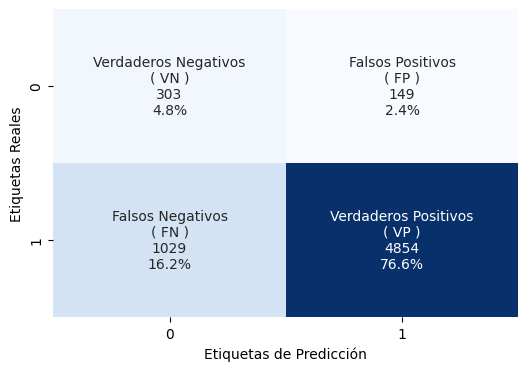

------------------------------------------------------------------------------------------------------------------------
RandomOverSampler
  Accuracy:	0.8078	(0.0065)
 Precision:	0.9748	(0.0024)
    Recall:	0.8141	(0.0078)
        F1:	0.8872	(0.0043)
    G-Mean:	0.7684	(0.0130)
   ROC AUC:	0.8437	(0.0140)


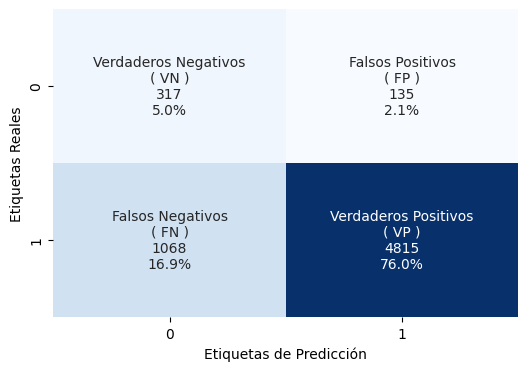

------------------------------------------------------------------------------------------------------------------------
SMOTEENN
  Accuracy:	0.7771	(0.0072)
 Precision:	0.9782	(0.0025)
    Recall:	0.7773	(0.0080)
        F1:	0.8663	(0.0049)
    G-Mean:	0.7758	(0.0128)
   ROC AUC:	0.8426	(0.0135)


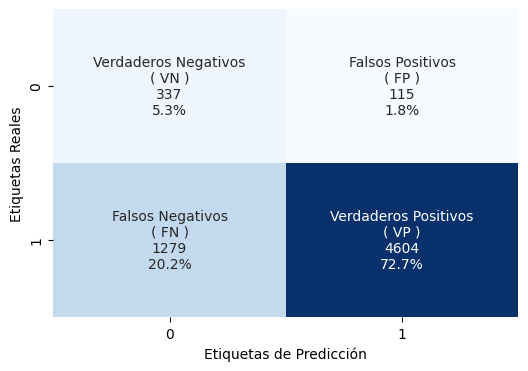

------------------------------------------------------------------------------------------------------------------------
SMOTETomek
  Accuracy:	0.8175	(0.0058)
 Precision:	0.9731	(0.0024)
    Recall:	0.8263	(0.0068)
        F1:	0.8937	(0.0038)
    G-Mean:	0.7617	(0.0145)
   ROC AUC:	0.8414	(0.0130)


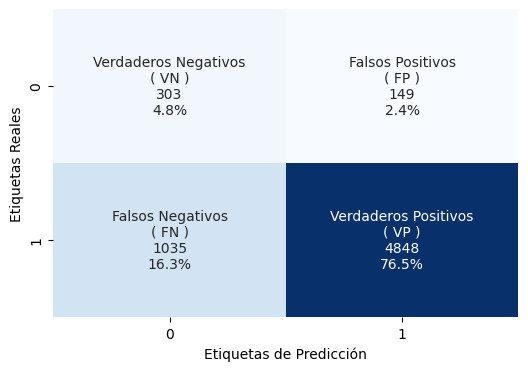

------------------------------------------------------------------------------------------------------------------------


In [126]:
modelos, nombres = get_resampling_models()

resultados = list()
preds = list()

for i in range(len(modelos)):
    resampling_model = modelos[i]

    base_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=100000)
    lr_pipeline = make_pipeline(
        resampling_model,
        RobustScaler(),
        PowerTransformer("yeo-johnson"),
        PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
        base_model,
    )


    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "f1": make_scorer(f1_score),
        "geometric_mean": make_scorer(geometric_mean_score),
        "roc_auc": "roc_auc",
    }

    scores = cross_validate(
        lr_pipeline, X_train, y_train, scoring=scoring, cv=kfold, n_jobs=-1
    )
    print(f'{nombres[i]}')
    print("%10s:\t%.4f\t(%.4f)"% ("Accuracy",np.mean(scores["test_accuracy"]),np.std(scores["test_accuracy"])))
    print("%10s:\t%.4f\t(%.4f)"% ("Precision",np.mean(scores["test_precision"]),np.std(scores["test_precision"])))
    print("%10s:\t%.4f\t(%.4f)"% ("Recall",np.mean(scores["test_recall"]),np.std(scores["test_recall"])))
    print("%10s:\t%.4f\t(%.4f)"% ("F1",np.mean(scores["test_f1"]),np.std(scores["test_f1"])))
    print("%10s:\t%.4f\t(%.4f)"% ("G-Mean",np.mean(scores["test_geometric_mean"]),np.std(scores["test_geometric_mean"])))
    print("%10s:\t%.4f\t(%.4f)"% ("ROC AUC",np.mean(scores["test_roc_auc"]),np.std(scores["test_roc_auc"])))

    resultados.append(scores)

    lr_pipeline.fit(X_train, y_train)
    _preds = lr_pipeline.predict(X_test)
    mi_cm(y_test, _preds)

    print('-'*120)



## Encontrar el modelo que tenga mejor recall

In [127]:
# find the model with the best recall
best_recall = 0
best_recall_model = None

for i in range(len(resultados)):
    recall = np.mean(resultados[i]["test_recall"])
    if recall > best_recall:
        best_recall = recall
        best_recall_model = nombres[i]

print(f"Best recall model: {best_recall_model} with recall: {best_recall:.4f}")

Best recall model: SMOTE with recall: 0.8269


# Modelo Baseline con Regresión Logística

In [128]:
lr_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    LogisticRegression(random_state=RANDOM_STATE, max_iter=100000),
)

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

In [129]:
print(y_test.shape, y_pred.shape)

(6335,) (6335,)


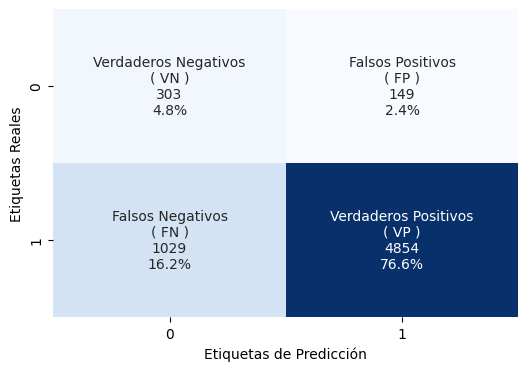

In [130]:
mi_cm(y_test, y_pred)

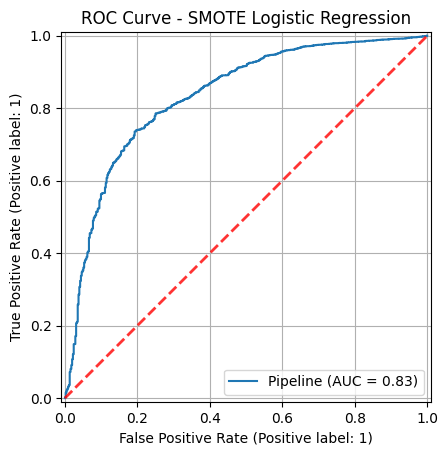

In [131]:
disp = RocCurveDisplay.from_estimator(lr_pipeline, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Logistic Regression")
plt.show()

# Exploración de modelos alternativos

## Regresión Lógistica

In [132]:
# optimización de hiperparámetros
base_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=100000)
lr_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    base_model,
)

param_grid = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__solver": ["saga", "liblinear"],
    "logisticregression__class_weight": ["balanced", None],
}

lr_grid_search = GridSearchCV(lr_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1, verbose=1)
lr_grid_result = lr_grid_search.fit(X_train, y_train)

print(f"Best: {lr_grid_result.best_score_} using {lr_grid_result.best_params_}")

Fitting 15 folds for each of 56 candidates, totalling 840 fits
Best: 0.8529505214167126 using {'logisticregression__C': 0.001, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [133]:
best_lr_model = lr_grid_search.best_estimator_
best_lr_model.fit(X_train, y_train)
y_pred = best_lr_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))


0.85194628590855
                   pre       rec       spe        f1       geo       iba       sup

          0       0.25      0.64      0.85      0.36      0.74      0.54       452
          1       0.97      0.85      0.64      0.91      0.74      0.56      5883

avg / total       0.92      0.84      0.66      0.87      0.74      0.56      6335



In [134]:
best_lr_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('robustscaler', RobustScaler()),
                ('powertransformer', PowerTransformer()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=100000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

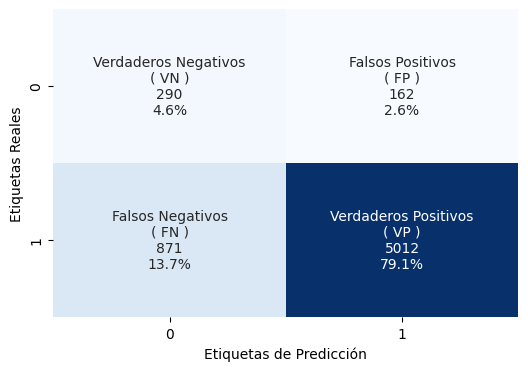

In [135]:
mi_cm(y_test, y_pred)

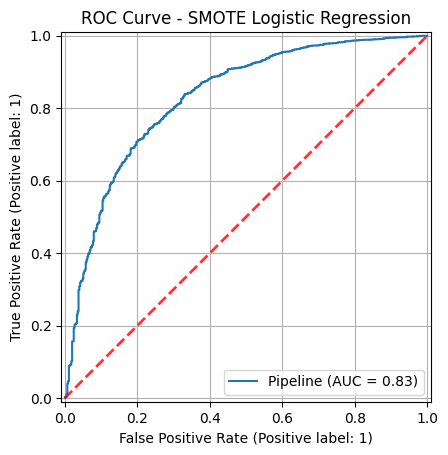

In [136]:
disp = RocCurveDisplay.from_estimator(best_lr_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Logistic Regression")
plt.show()

In [137]:
steps = np.linspace(0.1, 1.0, 25)

train_sizes, train_scores, test_scores = learning_curve(
    best_lr_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)


<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

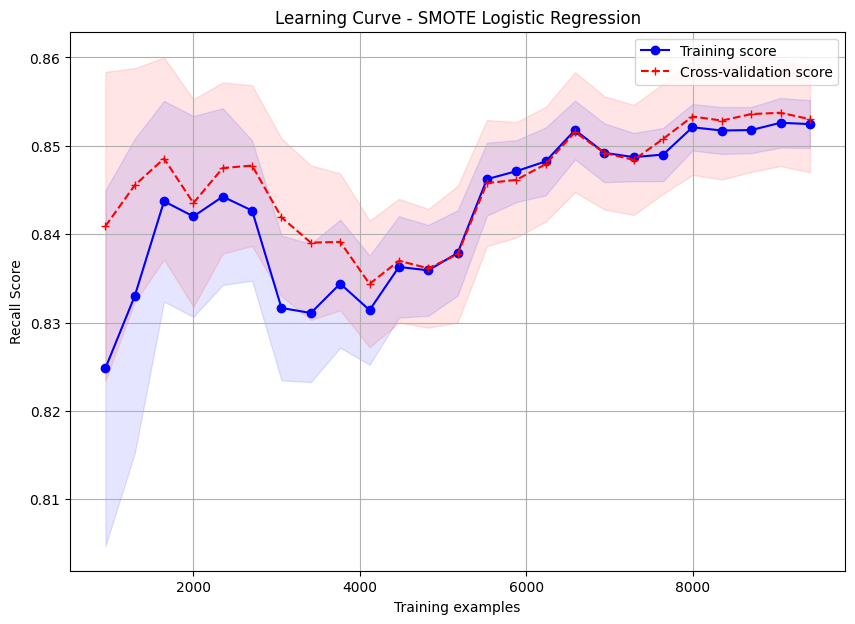

In [138]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE Logistic Regression",
    "Recall"
)

## Naive Bayes

In [139]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    nb_model,
)

param_grid = {
    "gaussiannb__var_smoothing": np.logspace(0, -9, num=100),
}

gnb_grid_search = GridSearchCV(nb_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1)
gnb_grid_result = gnb_grid_search.fit(X_train, y_train)

print(f"Best: {gnb_grid_result.best_score_} using {gnb_grid_result.best_params_}")

Best: 0.9086887850917319 using {'gaussiannb__var_smoothing': 1.0}


In [140]:
best_gnb_model = gnb_grid_search.best_estimator_
best_gnb_model.fit(X_train, y_train)
y_pred = best_gnb_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.9085500594934557
                   pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.53      0.91      0.39      0.69      0.46       452
          1       0.96      0.91      0.53      0.93      0.69      0.50      5883

avg / total       0.91      0.88      0.55      0.90      0.69      0.49      6335



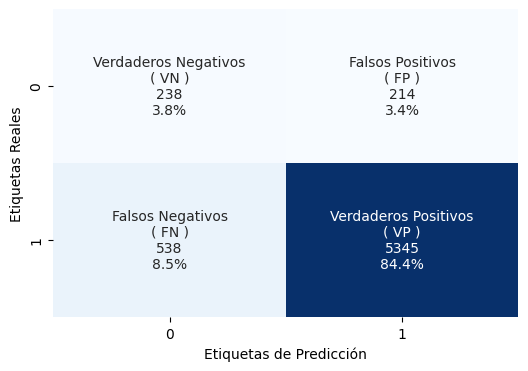

In [141]:
mi_cm(y_test, y_pred)

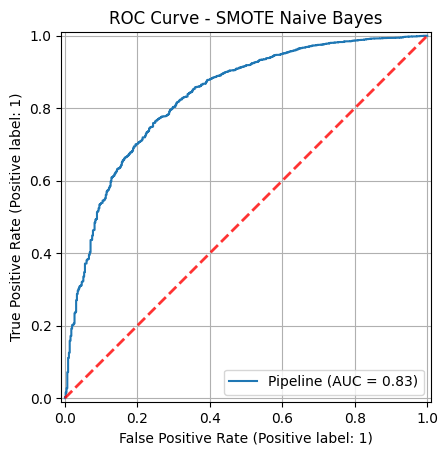

In [142]:
disp = RocCurveDisplay.from_estimator(best_gnb_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Naive Bayes")
plt.show()

In [143]:
train_sizes, train_scores, test_scores = learning_curve(
    best_gnb_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

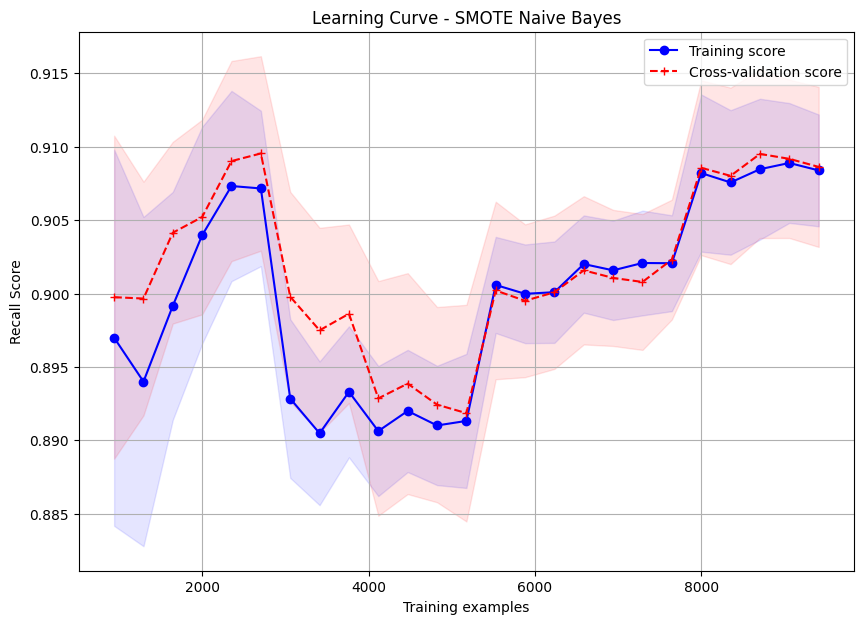

In [144]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE Naive Bayes",
    "Recall"
)

## SGD Classifier

In [145]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=RANDOM_STATE, max_iter=100000)
sgd_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    sgd_model,
)

param_grid = {
    "sgdclassifier__loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
    "sgdclassifier__penalty": ["l1", "l2", "elasticnet"],
    "sgdclassifier__alpha": [0.0001, 0.001, 0.01, 0.1],
}

sgd_grid_search = GridSearchCV(sgd_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1)
sgd_grid_result = sgd_grid_search.fit(X_train, y_train)

print(f"Best: {sgd_grid_result.best_score_} using {sgd_grid_result.best_params_}")

Best: 0.8589605303285663 using {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l1'}


In [146]:
best_sgd_model = sgd_grid_search.best_estimator_
best_sgd_model.fit(X_train, y_train)
y_pred = best_sgd_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8578956314805372
                   pre       rec       spe        f1       geo       iba       sup

          0       0.25      0.63      0.86      0.36      0.74      0.53       452
          1       0.97      0.86      0.63      0.91      0.74      0.56      5883

avg / total       0.92      0.84      0.65      0.87      0.74      0.55      6335



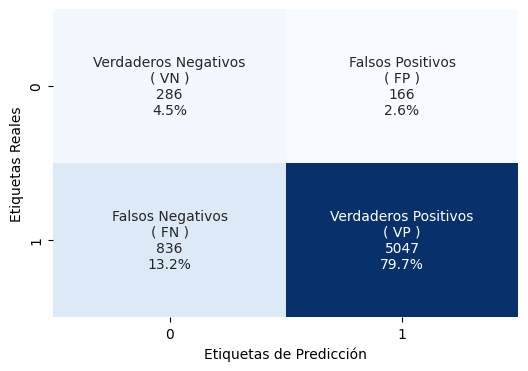

In [147]:
mi_cm(y_test, y_pred)

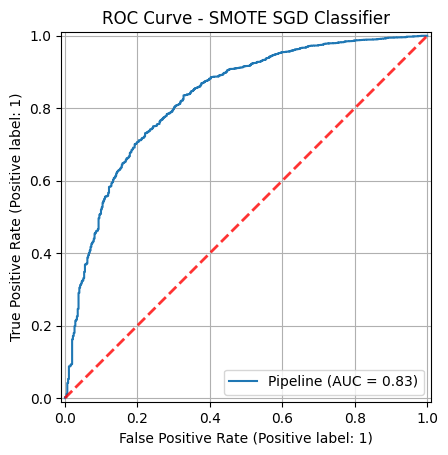

In [148]:
disp = RocCurveDisplay.from_estimator(best_sgd_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE SGD Classifier")
plt.show()

In [149]:
train_sizes, train_scores, test_scores = learning_curve(
    best_sgd_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

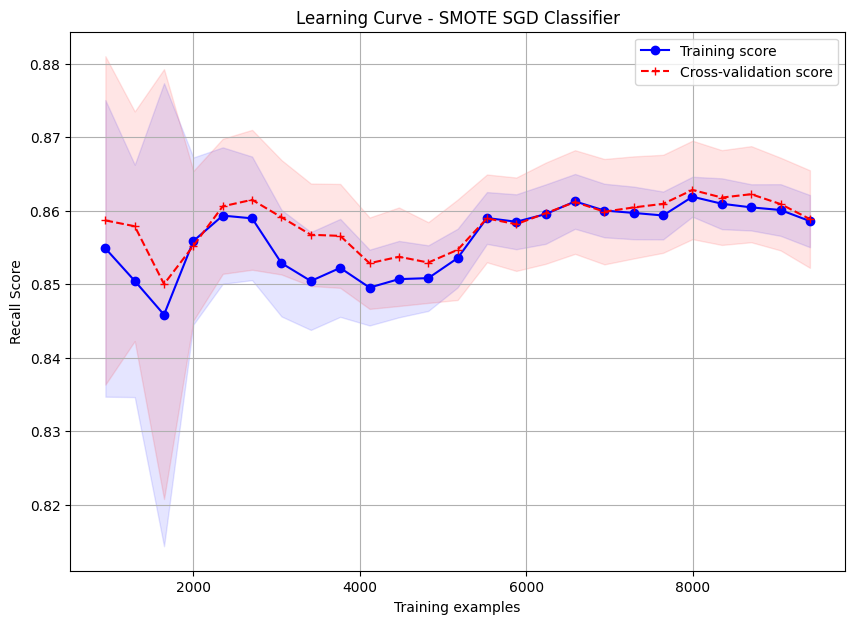

In [150]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE SGD Classifier",
    "Recall"
)

## KNeighbors Classifier

In [172]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

knn_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    knn_model,
)

param_grid = {
    "kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 11],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__metric": ["euclidean", "manhattan", "minkowski"],
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1)
knn_grid_result = knn_grid_search.fit(X_train, y_train)

print(f"Best: {knn_grid_result.best_score_} using {knn_grid_result.best_params_}")

Best: 0.8391611691626139 using {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}


In [173]:
best_knn_model = knn_grid_search.best_estimator_
best_knn_model.fit(X_train, y_train)
y_pred = best_knn_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8339282678905321
                   pre       rec       spe        f1       geo       iba       sup

          0       0.22      0.60      0.83      0.32      0.71      0.49       452
          1       0.96      0.83      0.60      0.89      0.71      0.52      5883

avg / total       0.91      0.82      0.62      0.85      0.71      0.51      6335



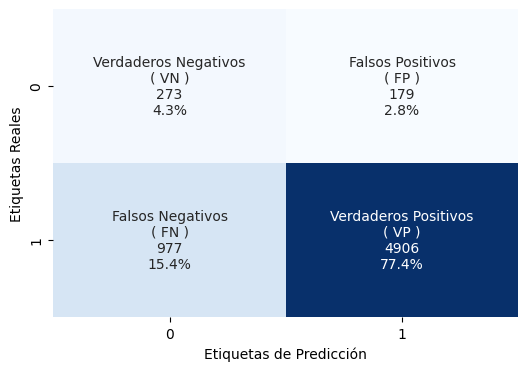

In [174]:
mi_cm(y_test, y_pred)

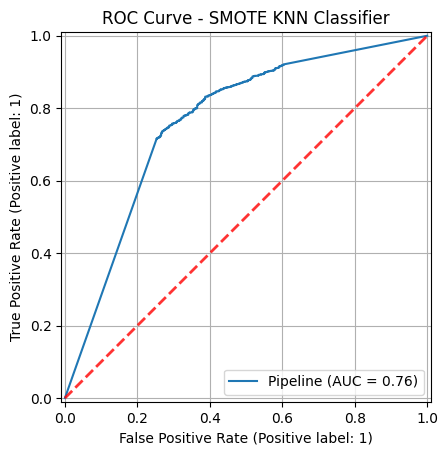

In [175]:
disp = RocCurveDisplay.from_estimator(best_knn_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE KNN Classifier")
plt.show()

In [176]:
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

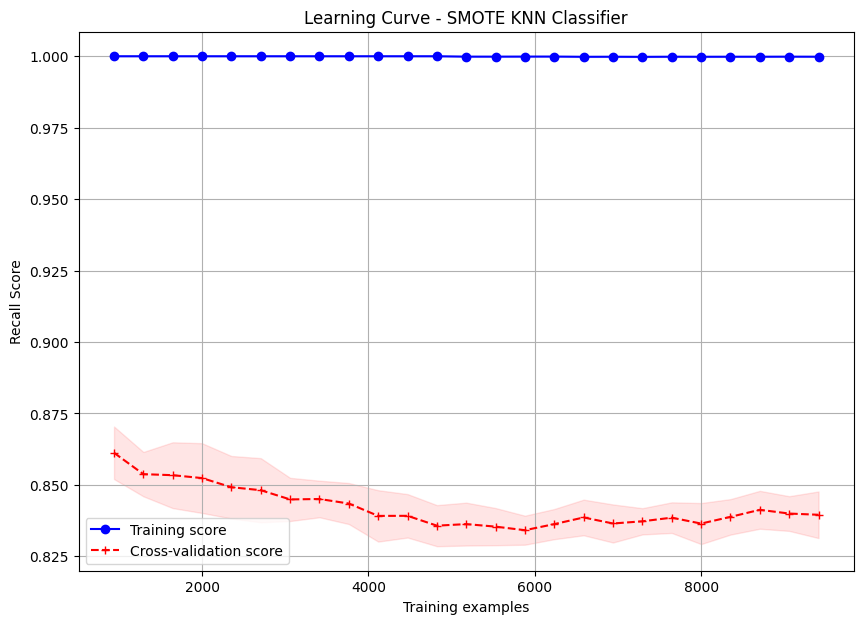

In [178]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE KNN Classifier",
    "Recall"
)

## Support Vector Machines
## SVC Classifier

Utilización de RandomizedSearchCV para optimizar hiperparámetros, ya que GridSearchCV es muy costoso en tiempo. para este modelo.

In [182]:
from sklearn import svm

svc_model = svm.SVC(random_state=RANDOM_STATE, probability=True, cache_size=1024, shrinking=False)
svc_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    svc_model,
)

param_grid = {
    # "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
}

svc_grid_search = GridSearchCV(
    svc_pipeline, param_grid, scoring="recall", cv=3, n_jobs=-1, verbose=1
)

svc_grid_result = svc_grid_search.fit(X_train, y_train)

print(f"Best: {svc_grid_result.best_score_} using {svc_grid_result.best_params_}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


Best: 0.8324180853011166 using {'svc__kernel': 'rbf'}


In [183]:
best_svc_model = svc_grid_result.best_estimator_
best_svc_model.fit(X_train, y_train)
y_pred = best_svc_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8334183239843618
                   pre       rec       spe        f1       geo       iba       sup

          0       0.24      0.69      0.83      0.36      0.76      0.57       452
          1       0.97      0.83      0.69      0.90      0.76      0.59      5883

avg / total       0.92      0.82      0.70      0.86      0.76      0.59      6335



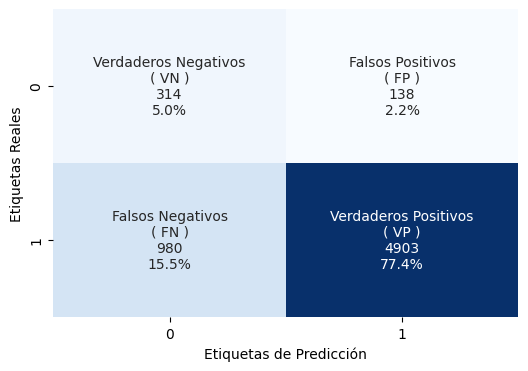

In [184]:
mi_cm(y_test, y_pred)

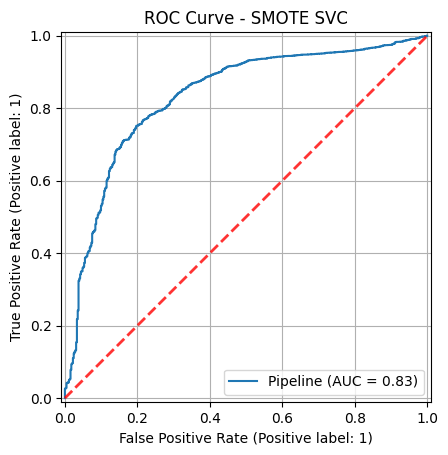

In [185]:
disp = RocCurveDisplay.from_estimator(best_svc_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE SVC")
plt.show()

In [186]:
train_sizes, train_scores, test_scores = learning_curve(
    best_svc_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

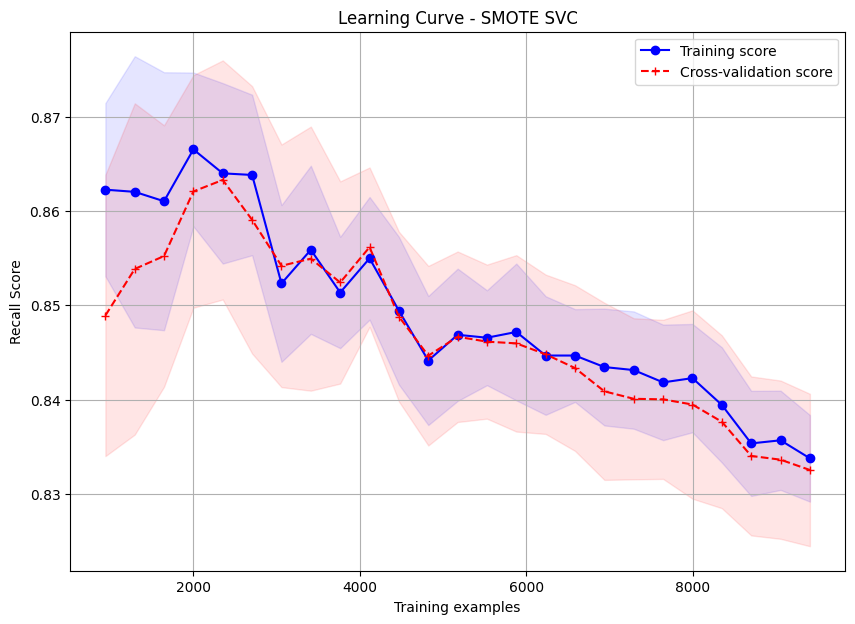

In [187]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE SVC",
    "Recall"
)

## Decision Trees

In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [152]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    dt_model,
)

param_grid = {
    "decisiontreeclassifier__criterion": ["gini", "log_loss", "entropy"],
    "decisiontreeclassifier__ccp_alpha": [0.001, 0.01, 0.1, 1, 0.99],
    "decisiontreeclassifier__max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    "decisiontreeclassifier__min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
}

dt_grid_search = RandomizedSearchCV(dt_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1, verbose=1)
dt_grid_result = dt_grid_search.fit(X_train, y_train)

print(f"Best: {dt_grid_result.best_score_} using {dt_grid_result.best_params_}")


Fitting 15 folds for each of 10 candidates, totalling 150 fits


Best: 0.83064900207478 using {'decisiontreeclassifier__min_samples_split': 9, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'log_loss', 'decisiontreeclassifier__ccp_alpha': 0.1}


In [153]:
best_dt_model = dt_grid_result.best_estimator_
best_dt_model.fit(X_train, y_train)
y_pred = best_dt_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8079211286758456
                   pre       rec       spe        f1       geo       iba       sup

          0       0.21      0.68      0.81      0.33      0.74      0.54       452
          1       0.97      0.81      0.68      0.88      0.74      0.56      5883

avg / total       0.92      0.80      0.69      0.84      0.74      0.56      6335



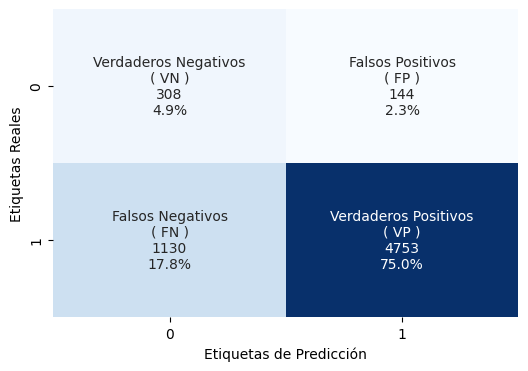

In [154]:
mi_cm(y_test, y_pred)

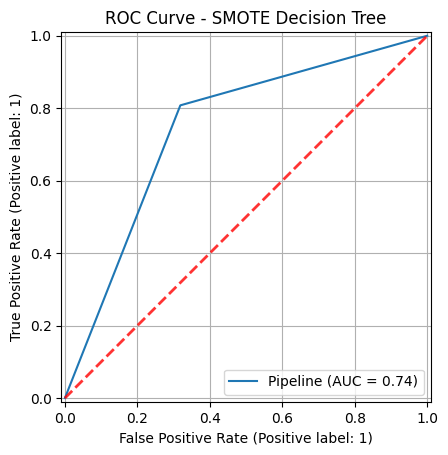

In [155]:
disp = RocCurveDisplay.from_estimator(best_dt_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Decision Tree")
plt.show()

In [156]:
train_sizes, train_scores, test_scores = learning_curve(
    best_dt_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

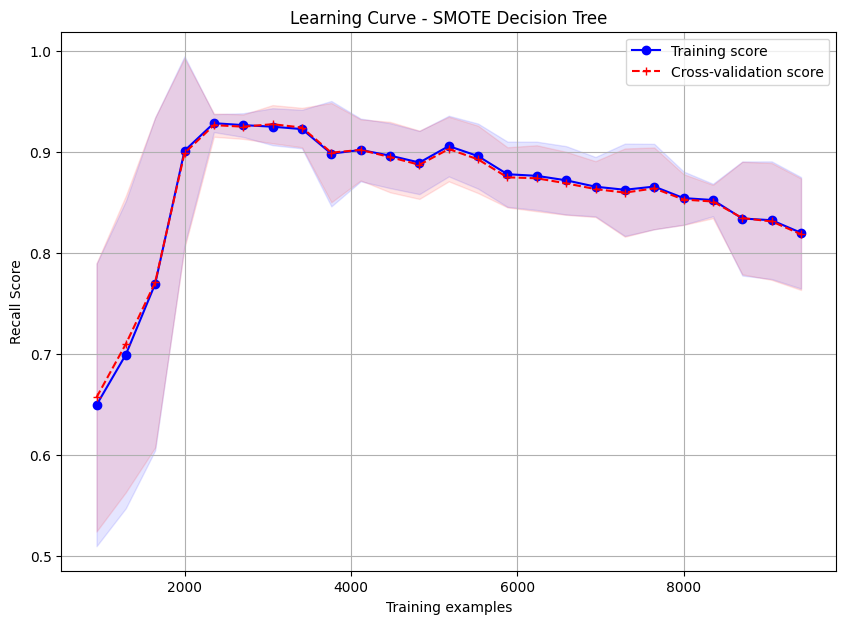

In [157]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE Decision Tree",
    "Recall"
)

## MLP Multi-layer Perceptron Classifier

In [158]:
from sklearn.neural_network import MLPClassifier

In [159]:
mlp_model = MLPClassifier(random_state=RANDOM_STATE, max_iter=5000)
mlp_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    mlp_model,
)

param_grid = {
    "mlpclassifier__hidden_layer_sizes": [(i, i) for i in range(5, 20, 2)],
    "mlpclassifier__alpha": [0.0001, 0.001, 0.01, 0.1, 0.99],
    "mlpclassifier__learning_rate_init": [0.001, 0.01, 0.1],
}

mlp_grid_search = GridSearchCV(mlp_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1, verbose=1)
mlp_grid_result = mlp_grid_search.fit(X_train, y_train)

print(f"Best: {mlp_grid_result.best_score_} using {mlp_grid_result.best_params_}")

Fitting 15 folds for each of 120 candidates, totalling 1800 fits
Best: 0.8441952428706916 using {'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (17, 17), 'mlpclassifier__learning_rate_init': 0.01}


In [160]:
best_mlp_model = mlp_grid_result.best_estimator_
best_mlp_model.fit(X_train, y_train)
y_pred = best_mlp_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8478667346591875
                   pre       rec       spe        f1       geo       iba       sup

          0       0.25      0.64      0.85      0.36      0.74      0.53       452
          1       0.97      0.85      0.64      0.90      0.74      0.56      5883

avg / total       0.92      0.83      0.66      0.87      0.74      0.56      6335



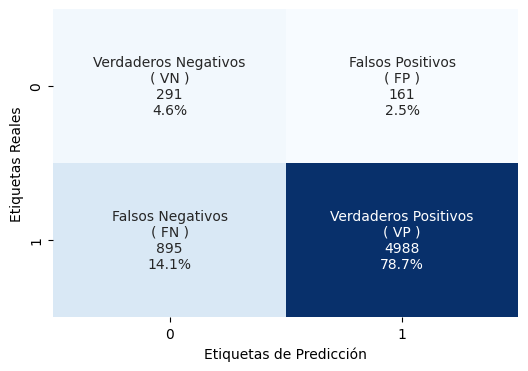

In [161]:
mi_cm(y_test, y_pred)

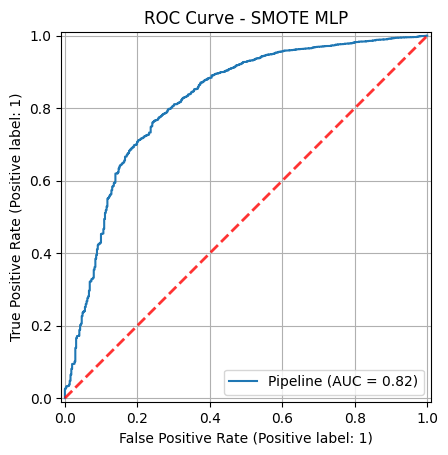

In [162]:
disp = RocCurveDisplay.from_estimator(best_mlp_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE MLP")
plt.show()

In [163]:
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

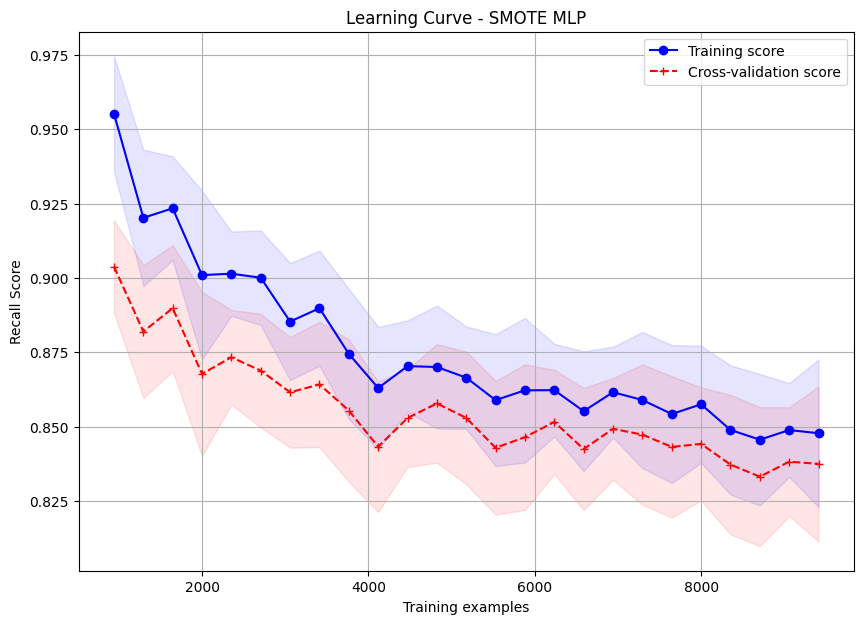

In [164]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE MLP",
    "Recall"
)

# ROC Curves of all best_models


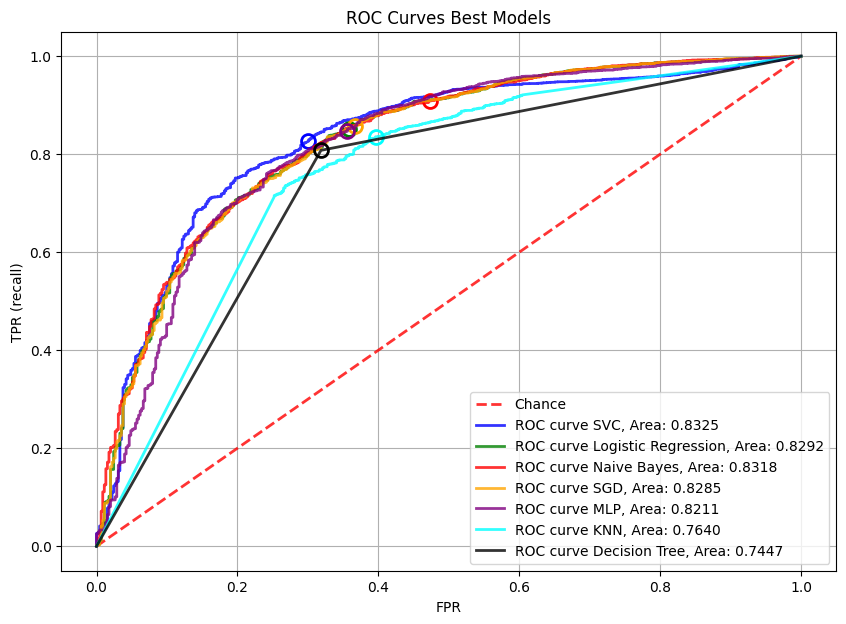

In [198]:
# https://ml-course.github.io/master/notebooks/04%20-%20Model%20Selection.html

from sklearn.metrics import auc, roc_curve



def plot_ROC_curves(models, Xb_test=X_test, yb_test=y_test, colors=["blue", "green", "red", "orange", "purple", "cyan", "black"]):
    fig = plt.figure(figsize=(10, 7))
    plt.grid(True)

    # random choose
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i, dict in enumerate(models):
        name, model = dict
        if hasattr(model, "predict_proba"):
            fpr, tpr, thresholds = roc_curve(
                yb_test, model.predict_proba(Xb_test)[:, 1])
            close_zero = np.argmin(np.abs(thresholds-0.5))
        else:
            fpr, tpr, thresholds = roc_curve(
                yb_test, model.decision_function(Xb_test))
            close_zero = np.argmin(np.abs(thresholds))
        plt.plot(fpr, tpr, lw=2, alpha=0.8, c=colors[i], label="ROC curve {}, Area: {:.4f}".format(name, auc(fpr, tpr)))
        plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
                 fillstyle="none", c=colors[i], mew=2) #label="Default threshold {}".format(model)
        plt.ylabel("TPR (recall)")
        plt.xlabel("FPR")
        plt.legend(loc="lower right",prop={"size":10})
        plt.title("ROC Curves Best Models")

best_models =  [
    ('SVC', best_svc_model),
    ('Logistic Regression', best_lr_model),
    ('Naive Bayes', best_gnb_model),
    ('SGD', best_sgd_model),
    ('MLP', best_mlp_model),
    ('KNN', best_knn_model),
    ('Decision Tree', best_dt_model),
]

plot_ROC_curves(models=best_models, Xb_test=X_test, yb_test=y_test)

# Brier Score de los mejores modelos

The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome. 

The score ranges from 0.0 to 1.0, where a score of 0.0 would indicate a perfect model.

In [208]:
from sklearn.metrics import brier_score_loss, roc_auc_score


scores = []
for name, model in best_models:
    preds = model.predict(X_test)

    scores.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "G-Mean": geometric_mean_score(y_test, preds),
        "ROC AUC": roc_auc_score(y_test, preds),
        "Brier Score Loss": brier_score_loss(y_test, preds),
    })


In [211]:
pd.options.display.float_format = "{:,.4f}".format
scores_df = pd.DataFrame(
    scores,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "G-Mean", "ROC AUC", "Brier Score Loss"]
)

# sort by lower brier score loss
scores_df.sort_values(by="Brier Score Loss", ascending=True)

,Model,Accuracy,Precision,Recall,F1,G-Mean,ROC AUC,Brier Score Loss
2,Naive Bayes,0.8813,0.9615,0.9086,0.9343,0.6917,0.7175,0.1187
3,SGD,0.8418,0.9682,0.8579,0.9097,0.7368,0.7453,0.1582
1,Logistic Regression,0.8369,0.9687,0.8519,0.9066,0.7393,0.7468,0.1631
4,MLP,0.8333,0.9687,0.8479,0.9043,0.7388,0.7458,0.1667
0,SVC,0.8235,0.9726,0.8334,0.8977,0.7609,0.7641,0.1765
5,KNN,0.8175,0.9648,0.8339,0.8946,0.7097,0.7190,0.1825
6,Decision Tree,0.7989,0.9706,0.8079,0.8818,0.7420,0.7447,0.2011


# Conclusiones

El objetivo de la entrega es la de comparar el desempeño de al menos 6 algoritmos de clasificación.

Comparar el rendimiento de los modelos y seleccionar los dos modelos que proporcionen el mejor rendimiento. 

De los 7 modelos evaluados en este avance, los dos modelos que proporcionan el mejor rendimiento en base a la métrica de Recall y la perdida de Brier son:
- Naive Bayes con Recall de 0.9086 y Brier Loss de 0.1187
- SGD cn Recall de 0.8579 y Brier Loss de 0.1592

Todos los algoritmos fueron evaluados con un pipeline que incluye el preprocesamiento de datos, balanceo de clases y selección de características.

Para todos los modelos se realizo una búsqueda de hiperparámetros con GridSearchCV y con RandomizedSearchCV en los arboles de decisión, el tiempo de búsqueda de los hiperparámetros fue relativamente corto para los modelos Naive Bayes, SGD, K-Nearest Neighbors, Regresión Logística y Árbol de decisión, la búsqueda de hiperparámetros de estos modelos no excedió más de 15 minutos en el peor de los casos, los modelos mas tardados en la búsqueda de hiperparámetros fueron el MLP y el SVC, el MLP tardo aproximadamente unos 30 minutos y el SVC con el espacio de búsqueda inicial que se dio no termino en un tiempo razonable por lo que se decidió únicamente hacer una búsqueda entre dos tipos de kernels sin búsqueda de otros hiperparámetros.

De acuerdo a los resultados obtenidos y a la importancia del negocio de minimizar los Falsos Positivos es el que mejores resultados obtuvo con 538 FN (8.5%) y 214 FP (3.4%) en el conjunto de prueba.

De igual forma el modelo es fácil de entrenar ya que no requiere de muchos recursos computacionales y el tiempo de entrenamiento es muy corto.

El modelo de SGD también obtuvo buenos resultados con 836 FN (13.2%) y 166 FP (2.6%) en el conjunto de prueba.


Como modelo final sugerimos Naive Bayes ya que es el que mejor se ajusta a las necesidades del negocio y es el que mejor rendimiento obtuvo en las métricas de Recall y Brier Loss.

La interpretabilidad del modelo es fácil de explicar y de entender, partiendo que el modelo es un clasificador que asume que las características son independientes entre sí, lo que lo hace fácil de explicar a personas no técnicas.

Las ventajas del modelo son :
- Fácil de implementar y es eficiente en tiempo de entrenamiento.
- Efectivo en conjuntos de datos con gran cantidad de características.
- Funciona bien incluso con conjuntos de datos pequeños.

Las desventajas del modelo son:
- Asume que las características son independientes entre sí, lo que no siempre es el caso.
- Puede ser influenciado por la presencia de características irrelevantes.
- Puede asignar probabilidades cercanas a 0 para eventos que no ha observado en el conjunto de entrenamiento.




